In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!ls /content/drive/MyDrive/dataset_final.zip


/content/drive/MyDrive/dataset_final.zip


In [15]:
!cp  "/content/drive/MyDrive/dataset_final.zip" /content/


In [16]:
!unzip -q /content/dataset_final.zip -d /content

In [17]:
!rm -rf /content/dataset_local
!mv /content/dataset_final /content/dataset_local


In [18]:
import os

DATA_DIR = '/content/dataset_local'

for person in os.listdir(DATA_DIR):
  path = os.path.join(DATA_DIR, person)
  print(person, "->", len(os.listdir(path)), "imagenes")


Karim Benzema -> 103 imagenes
Ursula Corbero -> 98 imagenes
Mark Zuckerberg -> 41 imagenes
Bobby Morley -> 78 imagenes
Mark Ruffalo -> 119 imagenes
Anthony Mackie -> 71 imagenes
Katharine Mcphee -> 137 imagenes
Alvaro Morte -> 70 imagenes
Emilia Clarke -> 112 imagenes
Virgil van Dijk -> 105 imagenes
Avril Lavigne -> 64 imagenes
Tom Ellis -> 126 imagenes
Shakira Isabel Mebarak -> 103 imagenes
Katherine Langford -> 105 imagenes
Alex Lawther -> 80 imagenes
Natalie Portman -> 95 imagenes
Amber Heard -> 95 imagenes
Danielle Panabaker -> 106 imagenes
Johnny Depp -> 111 imagenes
Sarah Wayne Callies -> 114 imagenes
Millie Bobby Brown -> 94 imagenes
Margot Robbie -> 98 imagenes
Lamine Yamal -> 92 imagenes
Pedro Alonso -> 76 imagenes
Andy Samberg -> 114 imagenes
Scarlett Johansson -> 95 imagenes
Maria Pedraza -> 62 imagenes
Zac Efron -> 109 imagenes
Iker Casillas -> 89 imagenes
Nadia Hilker -> 90 imagenes
Megan Fox -> 98 imagenes
Selena Gomez -> 74 imagenes
Emma Stone -> 65 imagenes
Tom Holland 

Importamos las librerias necesarias (esto despues deberia estar en requeriments.txt)


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


***PREPARAMOS EL GENERADOR DE IMAGENES, DIVIDIENDO EL DATASET EN EN DOS, PARA USARLO CON DATA AUGMENTATION Y VALIDACION***

In [20]:
#Ruta de donde obtenemos los datos
DATA_DIR = '/content/dataset_local'

#Parametros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32 #Podriamos modifcar para que tome más imagenes para entrenar, depende de nuestro GPU,

#Data augmentation para generar más imagenes y poder entrenar nuestro modelo
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split =0.2, #Esto lo podemos ir modificando para probar, 80% train, 20% para validar
    rotation_range=20,
    zoom_range = 0.2,
    horizontal_flip = True
)

#Generador para entrenamiento
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset ='training'
)

#Generador para validación
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset ='validation'
)

Found 10817 images belonging to 129 classes.
Found 2646 images belonging to 129 classes.


***Cargamos el modelo MOBILENETV2 y construimos el modelo fine-tuning, es el que nos interesa a nosotros***

In [21]:
#Cargamos el modelo preentrenado
base_model = MobileNetV2(
    weights='imagenet', #Esto utiliza los pesos preentrenados
    include_top=False, #Excluimos la capa final original, asi le damos el entrenamiento que nosotros queremos
    input_shape=(224, 224, 3)
)

#Detenemos las capas bases, ya que no necesitamos que se entrenen por el momento
for layer in base_model.layers:
  layer.trainable = False

#Agregamos las capas finales que son personalizadas
x = base_model.output
x = GlobalAveragePooling2D()(x) #Convierte los mapas de activacion en un vector, simplifica los parametros
x = Dropout(0.5)(x) #Evitamos sobreajustes, desactiva neuronas aleatoriamente para su entrenamiento
x = Dense(128, activation='relu')(x) #Esta es la capa intermedia de aprendizaje, aprende combinaciones de rasgos
predictions = Dense(129, activation='softmax')(x) #Numero de clases, es la capa final de clasificacion, predice una probabilidad por persona

#Construimos el modelo
model = Model(inputs=base_model.input, outputs=predictions)

#Lo compilamos
model.compile(
    optimizer=Adam(learning_rate=0.001), #Es un optimizador
    loss='categorical_crossentropy', #Funcion de perdida para multiclases
    metrics=['accuracy']
)

model.summary() #Utilizamos esto para ver si hay algun error con respecto a la cantidad de clases o los parametros que se van a entrenar

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,438,593 (9.30 MB)

 Trainable params: 180,609 (705.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

***Momento de entrenar al modelo***

In [22]:
#Entrenamos el modelo
history = model.fit(
    train_generator,
    validation_data = val_generator,
    epochs=10, #por ahora probamos con 30 epocas
    steps_per_epoch = len(train_generator),
    validation_steps = len(val_generator)
)

Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 194s 520ms/step - accuracy: 0.0435 - loss: 4.6819 - val_accuracy: 0.1088 - val_loss: 3.8629
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 149s 441ms/step - accuracy: 0.1313 - loss: 3.7797 - val_accuracy: 0.2048 - val_loss: 3.3867
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 151s 446ms/step - accuracy: 0.1975 - loss: 3.3828 - val_accuracy: 0.2200 - val_loss: 3.2012
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 149s 440ms/step - accuracy: 0.2274 - loss: 3.1782 - val_accuracy: 0.2309 - val_loss: 3.1317
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 204s 447ms/step - accuracy: 0.2527 - loss: 3.0309 - val_accuracy: 0.2872 - val_loss: 2.9167
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 150s 443ms/step - accuracy: 0.2665 - loss: 2.9490 - val_accuracy: 0.2933 - val_loss: 2.8592
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 151s 444ms/step - accuracy: 0.2856 - loss: 2.8729 - val_accuracy: 0.3159 - val_loss: 2.7863
Epoch 8/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 149s 440ms/step - accuracy: 0.2894 -

***Realizamos el FINE-TUNING para tener mejores resultados***

In [23]:
#Vemos cuántas capas tiene el MobileNetV2
print("Capas totales de MobileNet:", len(base_model.layers))
total_layers = len(base_model.layers)

#Descongelamos solo las ultimas 5 capas, ya que si descongelamos todo, se puede romper
fine_tune_at = total_layers - 5
print("Descongelando capas desde la numero: ", fine_tune_at)

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
  layer.trainable = True

#Recopilar con LR bajo
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

#Ahora entrenamos nuestro fine-tuning
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)



Capas totales de MobileNet: 154
Descongelando capas desde la numero:  149
Epoch 1/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 174s 480ms/step - accuracy: 0.2104 - loss: 3.4500 - val_accuracy: 0.2971 - val_loss: 3.0004
Epoch 2/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 151s 446ms/step - accuracy: 0.2702 - loss: 2.9644 - val_accuracy: 0.2732 - val_loss: 3.1995
Epoch 3/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 150s 444ms/step - accuracy: 0.3016 - loss: 2.7844 - val_accuracy: 0.2997 - val_loss: 3.0397
Epoch 4/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 152s 449ms/step - accuracy: 0.3265 - loss: 2.6882 - val_accuracy: 0.3035 - val_loss: 2.8269
Epoch 5/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 150s 442ms/step - accuracy: 0.3343 - loss: 2.6319 - val_accuracy: 0.3265 - val_loss: 2.7978
Epoch 6/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 153s 451ms/step - accuracy: 0.3496 - loss: 2.5582 - val_accuracy: 0.3254 - val_loss: 2.7906
Epoch 7/10
339/339 ━━━━━━━━━━━━━━━━━━━━ 150s 444ms/step - accuracy: 0.3569 - loss: 2.5250 - val_accuracy: 0.3141 - val_loss: 2.7795
Ep

***Ahora graficamos las curvas para ver si el modelo entrena bien, converge, etc***

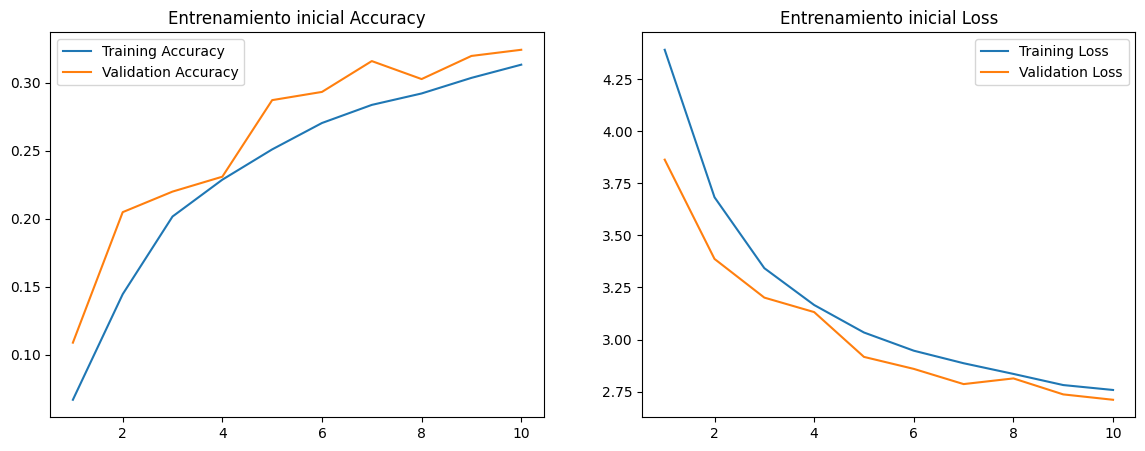

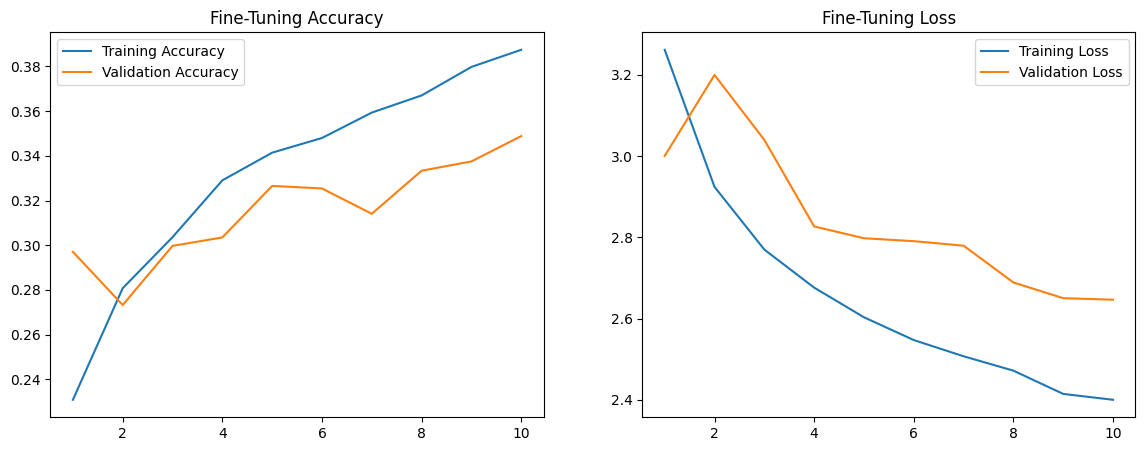

In [24]:
import matplotlib.pyplot as plt

def plot_history(history, title="Entrenamiento"):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history["loss"]
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)

  plt.figure(figsize=(14,5))

  #Accuracy
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label = 'Validation Accuracy')
  plt.title(title+' Accuracy')
  plt.legend()

  #Loss
  plt.subplot(1,2,2)
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs,val_loss, label = 'Validation Loss')
  plt.title(title+' Loss')
  plt.legend()

  plt.show()


#Curva del primer entrenamiento
plot_history(history, "Entrenamiento inicial")

#Curva del fine-tuning
plot_history(history_fine, "Fine-Tuning")

***Ahora guardamos el modelo para poder exportarlo si es necesario***

In [25]:
#Lo guardamos en el siguiente lugar
model_path = "face_recongnition_celebrity_model.h5"

#Guardamos el modelo
model.save(model_path)

print("Modelo guardado exitosamente en: ", model_path)

Modelo guardado exitosamente en:  face_recongnition_celebrity_model.h5


***Ahora hacemos el metodo para detectar el parecido a un famoso***

In [26]:
import numpy as np
import cv2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os

#Cargamos el modelo
model = tf.keras.models.load_model("/content/face_recongnition_celebrity_model.h5")
print("Modelo cargado correctamente.")

DATA_DIR = '/content/dataset_local'
class_names = sorted(os.listdir(DATA_DIR))
print("Clases detectadas:")
print(class_names)

#Funcion de prediccion
def predict_celebrity(image_path):
  #Cargamos la imagen con OpenCV
  img = cv2.imread(image_path)
  if img is None:
    print("No se pudo cargar la imagen")
    return

  #Convertimos la imagen BGR -> RGB
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  #Redimensionamos al tamaño que usa MobileNetV2 (ACA PODEMOS COLOCAR EL METODO QUE HIZO MATI QUE RECORTA LA IMAGEN QUE LE PASAMOS, EN VEZ DE USAR LA DE MobileNetV2)
  img_resized = cv2.resize(img_rgb,(224, 224))

  #Convertimos a array flotante y preprocesamos
  img_array = np.array(img_resized, dtype="float32")
  img_array = preprocess_input(img_array)
  img_array = np.expand_dims(img_array, axis = 0)

  #Hacemos la prediccion
  preds = model.predict(img_array)[0]

  #Obtenemos el indice mayor de probabilidad
  max_index = np.argmax(preds)

  #Obtenemos el nombre de la clase
  predicted_celebrity = class_names[max_index]

  #Obtenemos su probabilidad
  confidence = preds[max_index]

  return predicted_celebrity, confidence

Modelo cargado correctamente.
Clases detectadas:
['Adriana Lima', 'Alex Lawther', 'Alexandra Daddario', 'Alvaro Morte', 'Alycia Dabnem Carey', 'Amanda Crew', 'Amber Heard', 'Andy Samberg', 'Anne Hathaway', 'Anthony Mackie', 'Antoine Griezmann', 'Avril Lavigne', 'Barack Obama', 'Barbara Palvin', 'Ben Affleck', 'Bill Gates', 'Bobby Morley', 'Brenton Thwaites', 'Brian J. Smith', 'Brie Larson', 'Camila Mendes', 'Chris Evans', 'Chris Hemsworth', 'Chris Pratt', 'Christian Bale', 'Cristiano Ronaldo', 'Danielle Panabaker', 'David Beckham', 'Diego Maradona', 'Dominic Purcell', 'Dwayne Johnson', 'Eliza Taylor', 'Elizabeth Lail', 'Elizabeth Olsen', 'Ellen Page', 'Elon Musk', 'Emilia Clarke', 'Emma Stone', 'Emma Watson', 'Erling Haaland', 'Gal Gadot', 'Grant Gustin', 'Gwyneth Paltrow', 'Harry Kane', 'Henry Cavil', 'Hugh Jackman', 'Iker Casillas', 'Inbar Lavi', 'Irina Shayk', 'Jake Mcdorman', 'Jason Momoa', 'Jeff Bezos', 'Jennifer Lawrence', 'Jeremy Renner', 'Jessica Barden', 'Jimmy Fallon', 'Johan

***Probamos la funcion que definimos***

In [28]:
from google.colab import files
files.download("face_recongnition_celebrity_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
image = "/content/drive/MyDrive/Pruebas/prueba7.png"

celebrity, prob = predict_celebrity(image)
print("Prediccion: ", celebrity)
print("Confianza: ", round(prob*100,2),"%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Prediccion:  Virgil van Dijk
Confianza:  72.41 %
